<a href="https://colab.research.google.com/github/joaop06/PI-5_Semestre/blob/main/Pre_processamento_PI_5_(Crypto).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Grupo:**
- Gabriel Abramovick Bortoliero De Souza
- João Pedro Borges Campos
- Marcos Vinicius Hespanholo

**Base de Dados:** Top 100 Cryptocurrencies Historical Dataset  
**Fonte:** [Kaggle Dataset](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)

**Descrição do domínio:** Esta base de dados abrange a análise financeira e de mercado de criptomoedas, permitindo estudos sobre tendências de preços, volatilidade, volumes de negociação e correlações entre diferentes ativos digitais.

**Informações do BD:**
- **Quantidade de atributos:** 8 (Date, Open, High, Low, Close, Volume, Currency, Crypto)
- **Quantidade de exemplos:** 127.745
- **Tem valores ausentes:** Não
- **Total de criptomoedas analisadas:** 98

**Classes de Risco:**
- Alto Risco: 22 criptomoedas (24.18%)
- Médio Risco: 59 criptomoedas (64.84%)
- Baixo Risco: 10 criptomoedas (10.98%)
- Stablecoins: 7 criptomoedas


**Observações:**
- A classificação de risco é baseada em múltiplas métricas:
  - Volatilidade (40%)
  - Drawdown máximo (35%)
  - Beta (15%)
  - Liquidez (10%)
- Stablecoins recebem classificação específica devido à sua natureza única
- As métricas são calculadas considerando o histórico completo de preços e volumes

In [67]:
# Importação das bibliotecas necessárias
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder

# Configuração para exibir mais colunas
pd.set_option('display.max_columns', None)

## Carregando os dados

In [68]:
# Montar o Google Drive
drive.mount('/content/drive')

# Caminho da pasta onde estão os arquivos CSV
folder_path = '/content/drive/My Drive/Datasets/Top 100 Crypto Coins'

# Lista para armazenar os DataFrames individuais
dataframes = []

# Iterar sobre cada arquivo CSV na pasta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Ler o CSV
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)

        # Adicionar uma coluna para identificar a criptomoeda
        df['Crypto'] = os.path.splitext(file_name)[0]

        # Adicionar o DataFrame à lista
        dataframes.append(df)

# Concatenar todos os DataFrames em um único
combined_df = pd.concat(dataframes, ignore_index=True)

# Exibir informações sobre o DataFrame
print("Informações do DataFrame:")
print(combined_df.info())
print("\nPrimeiras linhas do DataFrame:")
display(combined_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127745 entries, 0 to 127744
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Date      127745 non-null  object 
 1   Open      127745 non-null  float64
 2   High      127745 non-null  float64
 3   Low       127745 non-null  float64
 4   Close     127745 non-null  float64
 5   Volume    127745 non-null  float64
 6   Currency  127745 non-null  object 
 7   Crypto    127745 non-null  object 
dtypes: float64(5), object(3)
memory usage: 7.8+ MB
None

Primeiras linhas do DataFrame:


,Date,Open,High,Low,Close,Volume,Currency,Crypto
0,2019-12-12,1.709804,1.875225,1.667567,1.821638,9469124.0,USD,Kusama
1,2019-12-13,1.822105,1.861582,1.678135,1.746984,7739639.0,USD,Kusama
2,2019-12-14,1.744522,2.016266,1.610543,1.935908,9237300.0,USD,Kusama
3,2019-12-15,1.935908,2.361329,1.673279,1.918206,8728553.0,USD,Kusama
4,2019-12-16,1.918206,2.099589,1.839443,1.955270,9682387.0,USD,Kusama


## Tratamento de atributos com valores ausentes

In [69]:
# índices das linhas que contém valores NaN
idxRowNan = pd.isnull(combined_df).any(axis=1).to_numpy().nonzero()

# verifica se há linhas com valores ausentes
if len(idxRowNan[0]) > 0:
    # imprime apenas as linhas com valores ausentes
    display(combined_df.iloc[idxRowNan])
else:
    print("Não há atributos com valores ausentes")


Não há atributos com valores ausentes


## Tratamento de Valores Ausentes

In [70]:
def handle_missing_values(df):

    # Verificar se as colunas necessárias existem
    required_columns = ['Date', 'Crypto', 'Open', 'High', 'Low', 'Close', 'Volume']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Colunas ausentes no DataFrame: {missing_columns}")

    # Criar cópia para não modificar o original
    df = df.copy()

    # Registrar quantidade inicial de valores ausentes
    print("Valores ausentes antes do tratamento:")
    print(df.isnull().sum())

    try:
        # Converter a coluna de data para datetime
        df['Date'] = pd.to_datetime(df['Date'])
    except Exception as e:
        print(f"Erro ao converter datas: {e}")
        print("Verificando formato das datas...")
        print(df['Date'].head())
        raise

    # Ordenar por criptomoeda e data
    df = df.sort_values(['Crypto', 'Date'])

    # Definir colunas de preço e volume
    price_columns = ['Open', 'High', 'Low', 'Close']

    # Tratar valores ausentes por criptomoeda
    for crypto in df['Crypto'].unique():
        mask = df['Crypto'] == crypto
        crypto_data = df.loc[mask]

        # Tratar preços
        for col in price_columns:
            # Verificar se há valores ausentes
            if crypto_data[col].isnull().any():
                # Tentar interpolação temporal
                df.loc[mask, col] = crypto_data[col].interpolate(
                    method='time',
                    limit_direction='both',
                    limit=5  # Limitar interpolação a 5 períodos
                )

                # Se ainda houver valores ausentes, usar interpolação linear
                if df.loc[mask, col].isnull().any():
                    df.loc[mask, col] = df.loc[mask, col].interpolate(
                        method='linear',
                        limit_direction='both'
                    )

                # Se ainda restarem valores ausentes, usar forward fill seguido de backward fill
                if df.loc[mask, col].isnull().any():
                    df.loc[mask, col] = df.loc[mask, col].fillna(method='ffill').fillna(method='bfill')

        # Tratar volume
        if crypto_data['Volume'].isnull().any():
            # Calcular média móvel de 7 dias para o volume
            rolling_mean = crypto_data['Volume'].rolling(window=7, center=True).mean()

            # Usar a média móvel para preencher valores ausentes
            df.loc[mask, 'Volume'] = crypto_data['Volume'].fillna(rolling_mean)

            # Se ainda houver valores ausentes, usar a média geral da criptomoeda
            if df.loc[mask, 'Volume'].isnull().any():
                mean_volume = crypto_data['Volume'].mean()
                df.loc[mask, 'Volume'] = df.loc[mask, 'Volume'].fillna(mean_volume)

    # Verificar consistência dos dados
    # Garantir que High >= Low
    mask = df['High'] < df['Low']
    if mask.any():
        print(f"Corrigindo {mask.sum()} registros onde High < Low")
        df.loc[mask, ['High', 'Low']] = df.loc[mask, ['Low', 'High']].values

    # Garantir que Open e Close estão entre High e Low
    for col in ['Open', 'Close']:
        # Corrigir valores acima do High
        mask = df[col] > df['High']
        if mask.any():
            print(f"Corrigindo {mask.sum()} registros onde {col} > High")
            df.loc[mask, col] = df.loc[mask, 'High']

        # Corrigir valores abaixo do Low
        mask = df[col] < df['Low']
        if mask.any():
            print(f"Corrigindo {mask.sum()} registros onde {col} < Low")
            df.loc[mask, col] = df.loc[mask, 'Low']

    # Verificar se ainda existem valores ausentes
    missing_after = df.isnull().sum()
    if missing_after.any():
        print("\nAinda existem valores ausentes após o tratamento:")
        print(missing_after[missing_after > 0])
    else:
        print("\nTodos os valores ausentes foram tratados com sucesso!")

    # Verificar valores negativos em colunas que não devem ter
    for col in price_columns + ['Volume']:
        neg_mask = df[col] < 0
        if neg_mask.any():
            print(f"\nEncontrados {neg_mask.sum()} valores negativos em {col}")
            # Substituir valores negativos por 0 ou pelo valor absoluto
            df.loc[neg_mask, col] = df.loc[neg_mask, col].abs()

    return df

try:
    # Aplicar tratamento de valores ausentes
    combined_df = handle_missing_values(combined_df)

except Exception as e:
    print(f"Erro durante o tratamento dos dados: {e}")
    raise

Valores ausentes antes do tratamento:
Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
Crypto      0
dtype: int64
Corrigindo 16 registros onde Open > High
Corrigindo 20 registros onde Open < Low

Todos os valores ausentes foram tratados com sucesso!

Encontrados 1 valores negativos em Low


### Tratamento de Dados Inconsistentes e Redundantes

In [71]:
def remove_inconsistencies(df):
    # Remover duplicatas exatas
    df = df.drop_duplicates()

    # Remover duplicatas considerando apenas os dados de preço e volume
    price_volume_cols = ['Date', 'Crypto', 'Open', 'High', 'Low', 'Close', 'Volume']
    df = df.drop_duplicates(subset=price_volume_cols, keep='first')

    return df

# Remover inconsistências
combined_df = remove_inconsistencies(combined_df)
print("Quantidade de registros após remoção de inconsistências:", len(combined_df))


Quantidade de registros após remoção de inconsistências: 127745


In [72]:
# Mostrar estatísticas básicas após o tratamento
print("\nEstatísticas básicas após o tratamento:")
print(combined_df.describe())



Estatísticas básicas após o tratamento:
                                Date           Open           High  \
count                         127745  127745.000000  127745.000000   
mean   2020-05-30 14:14:08.196015360     805.504686     831.308489   
min              2010-07-18 00:00:00       0.000000       0.000000   
25%              2019-06-07 00:00:00       0.265870       0.279388   
50%              2020-10-04 00:00:00       2.018000       2.127907   
75%              2021-09-18 00:00:00      25.102846      26.345259   
max              2022-08-23 00:00:00   67545.580000   85563.984375   
std                              NaN    5244.551072    5400.136537   

                 Low          Close        Volume  
count  127745.000000  127745.000000  1.277450e+05  
mean      777.513106     805.780348  3.216540e+08  
min         0.000000       0.000000  0.000000e+00  
25%         0.252109       0.266232  1.653093e+06  
50%         1.911000       2.019835  2.141148e+07  
75%        23.76

### Normalização e Scaling dos Dados

In [73]:
def finance_scaling(df):
    df = df.copy()

    # Log-normalização para volumes
    df['Volume'] = np.log1p(df['Volume'])

    # Calcular retornos percentuais para preços
    price_columns = ['Open', 'High', 'Low', 'Close']
    for col in price_columns:
        df[f'{col}_return'] = df.groupby('Crypto')[col].pct_change()

    # Preencher os valores NaN gerados pelo pct_change com 0
    return_columns = [f'{col}_return' for col in price_columns]
    df[return_columns] = df[return_columns].fillna(0)

    return df

# Aplicar scaling
combined_df = finance_scaling(combined_df)
print("\nColunas após transformações:")
display(combined_df.columns)



Colunas após transformações:


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Currency', 'Crypto',
       'Open_return', 'High_return', 'Low_return', 'Close_return'],
      dtype='object')

## Análise Exploratória

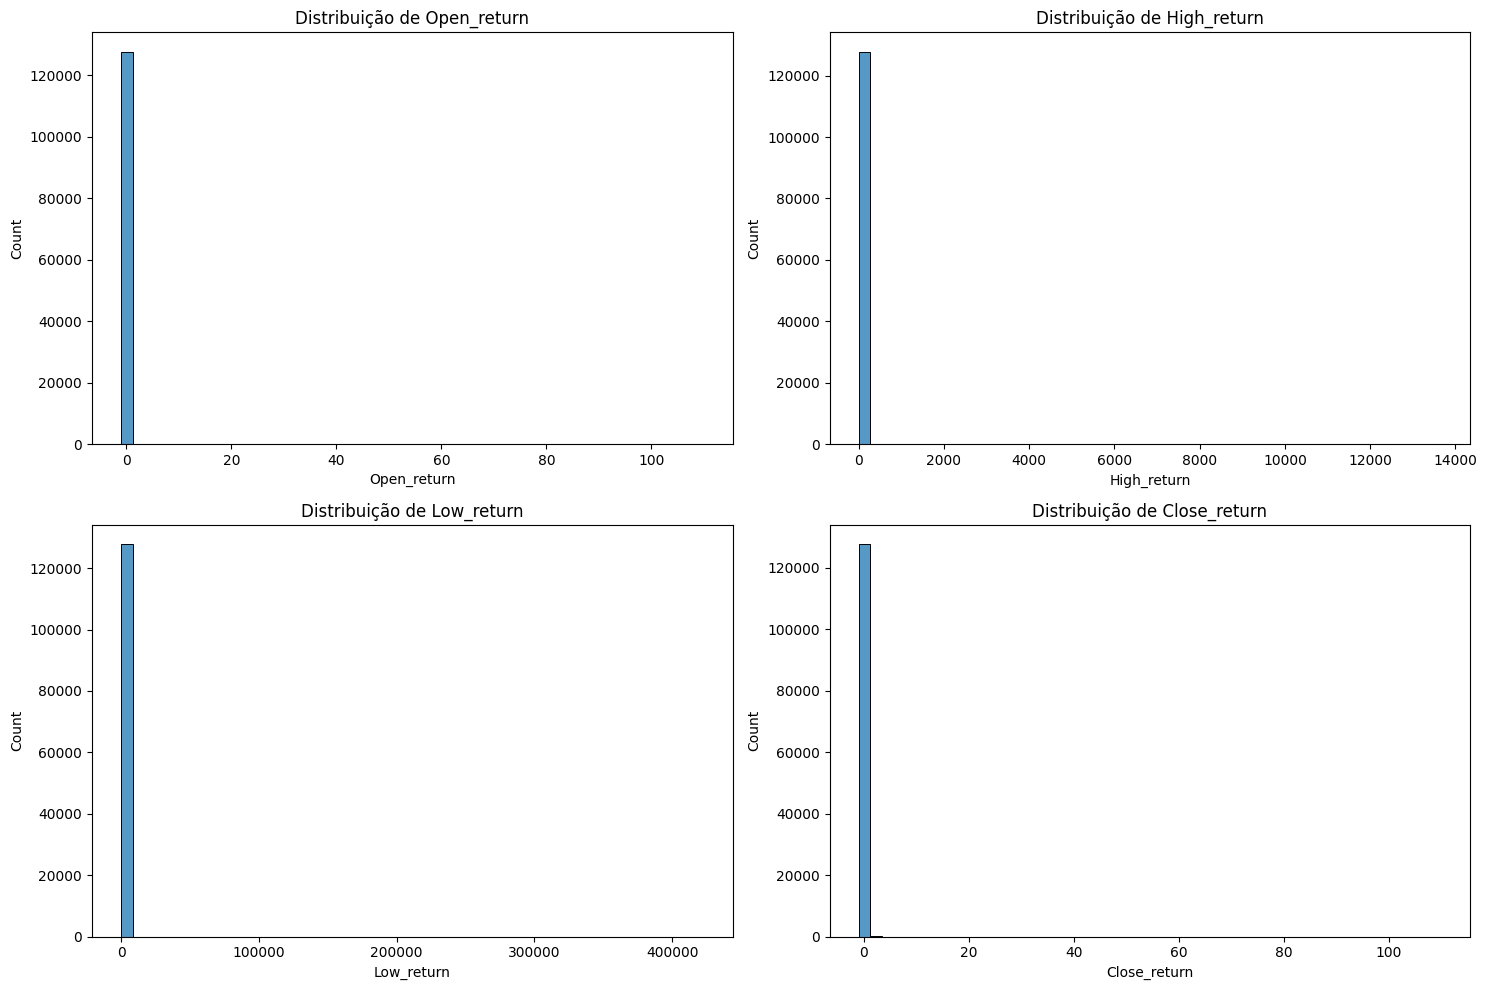

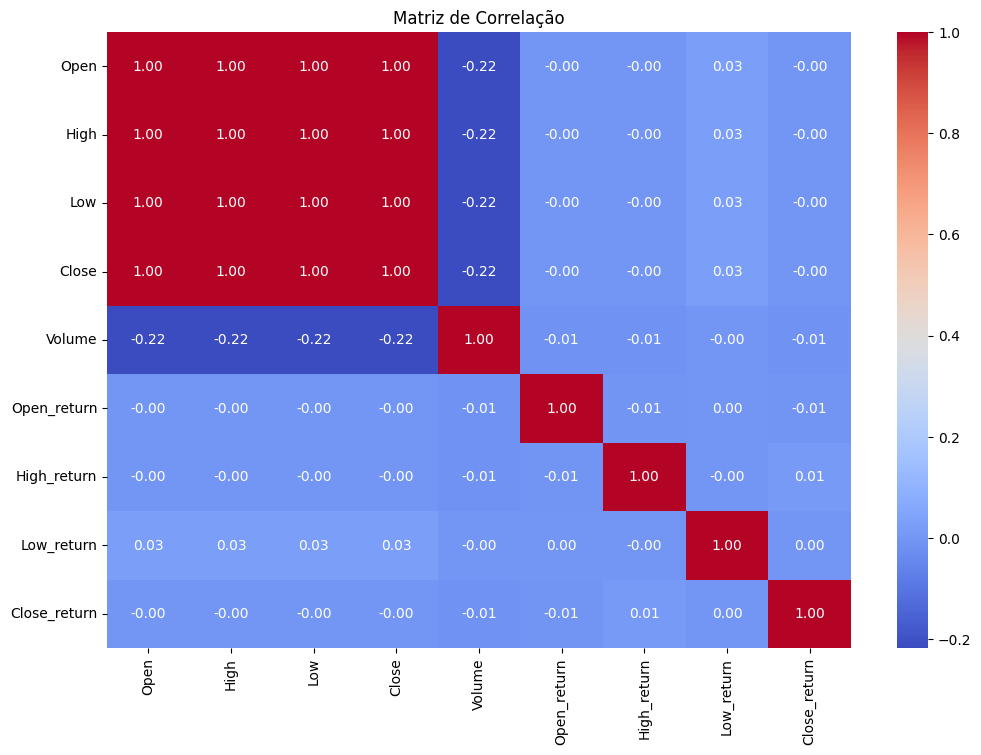

In [74]:
# Criar visualizações para os retornos
return_columns = [col for col in combined_df.columns if col.endswith('_return')]

plt.figure(figsize=(15, 10))
for i, col in enumerate(return_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=combined_df, x=col, bins=50)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Análise de correlação
numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
correlation = combined_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()


## Classificação de Risco

In [75]:
def calculate_volatility(returns, min_periods=30):
    """
    Calcula volatilidade com tratamento de dados
    """
    # Remover valores infinitos e NaN
    clean_returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

    if len(clean_returns) < min_periods:
        return np.nan

    try:
        # Usar desvio padrão tradicional em vez do MAD
        volatility = clean_returns.std() * np.sqrt(252)
        return volatility if not np.isnan(volatility) else np.nan
    except Exception:
        return np.nan

def calculate_risk_metrics(df, crypto_name, min_periods=30):
    '''
    Calcula métricas de risco para uma criptomoeda específica com tratamento robusto de dados
    '''
    try:
        # Filtrar e ordenar dados da criptomoeda
        crypto_data = df[df['Crypto'] == crypto_name].sort_values('Date')

        if len(crypto_data) < min_periods:
            print(f"Aviso: {crypto_name} tem menos que {min_periods} períodos de dados")
            return create_default_metrics()

        # 1. Volatilidade
        volatility = calculate_volatility(crypto_data['Close_return'], min_periods)

        # 2. Drawdown Máximo
        try:
            returns = crypto_data['Close_return'].replace([np.inf, -np.inf], np.nan)
            returns = returns[np.abs(returns) < returns.std() * 4]  # Remove outliers extremos
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding(min_periods=1).max()
            drawdowns = (cumulative_returns - rolling_max) / rolling_max
            max_drawdown = abs(drawdowns.min())
        except Exception:
            max_drawdown = np.nan

        # 3. Beta
        try:
            market_returns = df.groupby('Date')['Close_return'].mean()
            crypto_returns = crypto_data.set_index('Date')['Close_return']
            common_idx = market_returns.index.intersection(crypto_returns.index)

            if len(common_idx) >= min_periods:
                # Limpar e alinhar os dados
                market_clean = market_returns[common_idx].replace([np.inf, -np.inf], np.nan)
                crypto_clean = crypto_returns[common_idx].replace([np.inf, -np.inf], np.nan)

                # Remover NaN
                valid_mask = ~(market_clean.isna() | crypto_clean.isna())
                market_clean = market_clean[valid_mask]
                crypto_clean = crypto_clean[valid_mask]

                if len(market_clean) >= min_periods:
                    covariance = np.cov(crypto_clean, market_clean)[0,1]
                    market_variance = np.var(market_clean)
                    beta = covariance / market_variance if market_variance != 0 else np.nan
                else:
                    beta = np.nan
            else:
                beta = np.nan
        except Exception:
            beta = np.nan

        # 4. Liquidez
        try:
            volume_days = len(crypto_data[crypto_data['Volume'] > 0])
            total_days = len(crypto_data)

            liquidity = volume_days / total_days if total_days > 0 else 0

            # Normalizar volume
            avg_volume = crypto_data['Volume'].mean()
            norm_volume = min(1, avg_volume / crypto_data['Volume'].max()) if crypto_data['Volume'].max() > 0 else 0

            # Combinar métricas
            liquidity_score = 0.7 * liquidity + 0.3 * norm_volume
        except Exception:
            liquidity_score = np.nan

        metrics = {
            'Volatility': volatility,
            'Max_Drawdown': max_drawdown,
            'Beta': beta,
            'Liquidity': liquidity_score
        }

        # Validar resultados finais
        for key, value in metrics.items():
            if pd.isna(value) or np.isinf(value):
                metrics[key] = np.nan

        return metrics

    except Exception as e:
        print(f"Erro ao calcular métricas para {crypto_name}: {e}")
        return create_default_metrics()

def create_default_metrics():
    '''Cria um dicionário com valores padrão para métricas de risco'''
    return {
        'Volatility': np.nan,
        'Max_Drawdown': np.nan,
        'Beta': np.nan,
        'Liquidity': np.nan
    }


def is_stablecoin(crypto_name):
    '''
    Identifica se uma criptomoeda é uma stablecoin
    '''
    stablecoins = [
        'USDT', 'USDC', 'BUSD', 'DAI', 'TUSD', 'USDD', 'USDP', 'GUSD',
        'Tether', 'USD Coin', 'Binance USD', 'Dai', 'TrueUSD', 'Pax Dollar',
        'tether', 'Pax Dollar', 'USDD'
    ]
    return any(stable.lower() in crypto_name.lower() for stable in stablecoins)

def classify_risk(metrics, crypto_name=None):
    '''
    Classifica o risco com tratamento especial para stablecoins e ajuste nos limiares
    '''
    # Verificar se é stablecoin
    if crypto_name and is_stablecoin(crypto_name):
        return "Stablecoin"

    # Verificar dados suficientes para classificação
    required_metrics = ['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity']
    available_metrics = [m for m in required_metrics if not np.isnan(metrics[m])]

    if len(available_metrics) < 2:
        return "Não classificável"

    # Sistema de pontuação com limiares ajustados
    risk_scores = {
        'Volatility': {
            'weight': 0.40,
            'thresholds': [1.0, 2.0],
            'score': 0
        },
        'Max_Drawdown': {
            'weight': 0.35,
            'thresholds': [0.6, 0.85],
            'score': 0
        },
        'Beta': {
            'weight': 0.15,
            'thresholds': [0.5, 1.2],
            'score': 0
        },
        'Liquidity': {
            'weight': 0.10,
            'thresholds': [0.8, 0.9],
            'score': 0
        }
    }

    # Regras especiais para classificação automática de alto risco
    if metrics['Volatility'] > 5.0 or metrics['Beta'] > 3.0:
        return "Alto"

    # Calcular pontuação para cada métrica
    for metric, config in risk_scores.items():
        if not np.isnan(metrics[metric]):
            value = metrics[metric]

            if metric == 'Liquidity':
                if value >= config['thresholds'][1]:
                    config['score'] = 1.0
                elif value <= config['thresholds'][0]:
                    config['score'] = 0.0
                else:
                    config['score'] = (value - config['thresholds'][0]) / (config['thresholds'][1] - config['thresholds'][0])
            else:
                if value <= config['thresholds'][0]:
                    config['score'] = 1.0
                elif value >= config['thresholds'][1]:
                    config['score'] = 0.0
                else:
                    config['score'] = 1.0 - (value - config['thresholds'][0]) / (config['thresholds'][1] - config['thresholds'][0])

    # Calcular pontuação final ponderada
    total_weight = sum(v['weight'] for k, v in risk_scores.items() if not np.isnan(metrics[k]))
    weighted_score = sum(v['weight'] * v['score'] for k, v in risk_scores.items() if not np.isnan(metrics[k]))

    if total_weight == 0:
        return "Não classificável"

    final_score = weighted_score / total_weight

    if final_score >= 0.70:
        return "Baixo"
    elif final_score >= 0.45:
        return "Médio"
    else:
        return "Alto"

def create_risk_profile(df):
    '''
    Cria perfil de risco completo com análise detalhada e separação de stablecoins
    '''
    risk_profiles = []
    unique_cryptos = df['Crypto'].unique()

    print(f"\nAnalisando {len(unique_cryptos)} criptomoedas...\n")

    for crypto in unique_cryptos:
        metrics = calculate_risk_metrics(df, crypto)
        risk_level = classify_risk(metrics, crypto)

        profile = {
            'Crypto': crypto,
            'Risk_Level': risk_level,
            **metrics
        }
        risk_profiles.append(profile)

    results_df = pd.DataFrame(risk_profiles)

    # Relatório detalhado
    print("\nResumo da análise:")
    print(f"Total de criptomoedas analisadas: {len(results_df)}")
    stablecoins = results_df[results_df['Risk_Level'] == 'Stablecoin']
    print(f"Stablecoins identificadas: {len(stablecoins)}")

    # Análise excluindo stablecoins
    non_stable = results_df[results_df['Risk_Level'] != 'Stablecoin']
    print("\nDistribuição de risco (excluindo stablecoins):")
    risk_dist = non_stable['Risk_Level'].value_counts()
    print(risk_dist)

    print("\nEstatísticas por nível de risco (excluindo stablecoins):")
    for risk_level in ['Alto', 'Médio', 'Baixo']:
        if risk_level in risk_dist.index:
            subset = non_stable[non_stable['Risk_Level'] == risk_level]
            print(f"\n{risk_level} Risco ({len(subset)} criptomoedas):")
            print(f"Volatilidade média: {subset['Volatility'].mean():.2f}")
            print(f"Drawdown médio: {subset['Max_Drawdown'].mean():.2f}")
            print(f"Beta médio: {subset['Beta'].mean():.2f}")
            print(f"Liquidez média: {subset['Liquidity'].mean():.2f}")

    print("\nTop 5 criptomoedas mais voláteis (excluindo stablecoins):")
    print(non_stable.nlargest(5, 'Volatility')[['Crypto', 'Volatility', 'Risk_Level']])

    print("\nStablecoins identificadas:")
    if len(stablecoins) > 0:
        print(stablecoins[['Crypto', 'Volatility']])

    # Análise de risco adicional
    high_vol = len(non_stable[non_stable['Volatility'] > 3])
    high_dd = len(non_stable[non_stable['Max_Drawdown'] > 0.9])
    high_beta = len(non_stable[non_stable['Beta'] > 1.5])

    print("\nIndicadores de risco:")
    print(f"- {high_vol} criptomoedas têm volatilidade muito alta (>300%)")
    print(f"- {high_dd} criptomoedas têm drawdown significativo (>90%)")
    print(f"- {high_beta} criptomoedas têm beta elevado (>1.5)")

    return results_df

# Criar perfil de risco com tratamento de erros
try:
    risk_profile_df = create_risk_profile(combined_df)
except Exception as e:
    print(f"Erro na criação do perfil de risco: {e}")
    risk_profile_df = pd.DataFrame()


Analisando 98 criptomoedas...


Resumo da análise:
Total de criptomoedas analisadas: 98
Stablecoins identificadas: 7

Distribuição de risco (excluindo stablecoins):
Risk_Level
Médio    59
Alto     22
Baixo    10
Name: count, dtype: int64

Estatísticas por nível de risco (excluindo stablecoins):

Alto Risco (22 criptomoedas):
Volatilidade média: 11.08
Drawdown médio: 0.96
Beta médio: 3.88
Liquidez média: 0.88

Médio Risco (59 criptomoedas):
Volatilidade média: 1.22
Drawdown médio: 0.93
Beta médio: 0.40
Liquidez média: 0.94

Baixo Risco (10 criptomoedas):
Volatilidade média: 0.65
Drawdown médio: 0.54
Beta médio: 0.17
Liquidez média: 0.84

Top 5 criptomoedas mais voláteis (excluindo stablecoins):
       Crypto  Volatility Risk_Level
3     ApeCoin   67.191056       Alto
1        Aave   61.586316       Alto
16   Compound   52.017461       Alto
79   dogecoin   22.578961       Alto
62  The Graph    9.621608       Alto

Stablecoins identificadas:
         Crypto  Volatility
8   Binance USD   

## Distribuição das classes

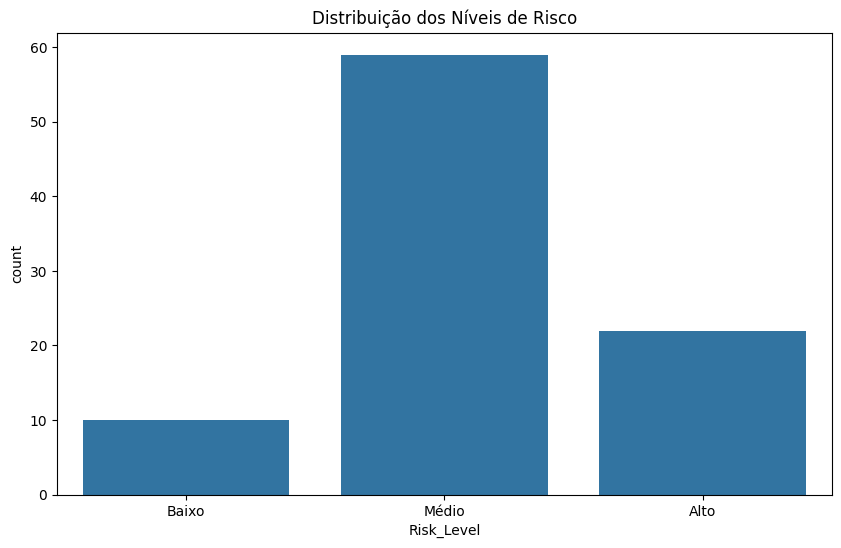

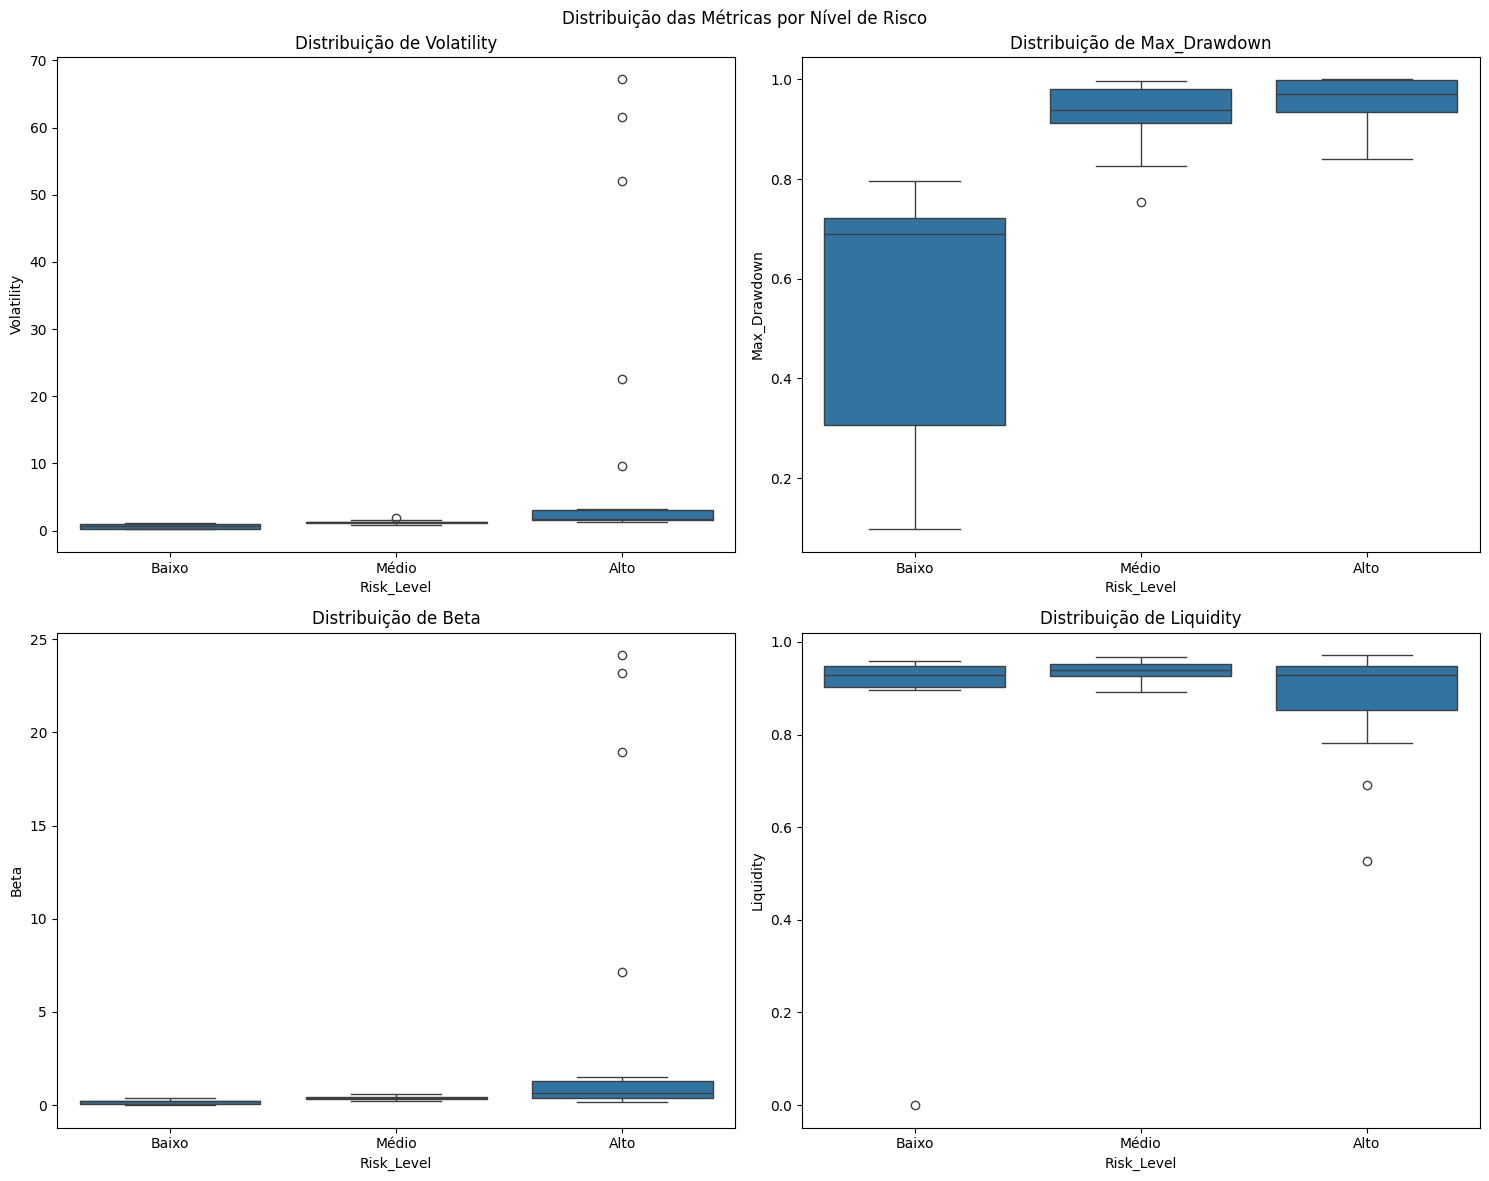


Estatísticas Detalhadas por Nível de Risco:


Volatility                        Max_Drawdown                \
                 mean     std    min     max         mean    std    min   
Risk_Level                                                                
Alto           11.081  20.673  1.202  67.191        0.962  0.043  0.841   
Baixo           0.649   0.355  0.180   1.091        0.544  0.268  0.097   
Médio           1.218   0.179  0.854   1.830        0.933  0.051  0.754   
Stablecoin      0.086   0.034  0.059   0.145        0.062  0.028  0.024   

                    Beta                       Liquidity                       
              max   mean    std    min     max      mean    std    min    max  
Risk_Level                                                                     
Alto        1.000  3.881  7.588  0.194  24.141     0.882  0.108  0.526  0.972  
Baixo       0.797  0.171  0.134  0.006   0.402     0.838  0.295  0.000  0.959  
Médio       0.997  0.397  0.088  0.206   0.576     0.938  0.018  0.893  0.967  
Stablecoin  0.104  0.002  0.012 -0.005   0.028     0.939  0.028  0.886  0.973


Perfil de risco salvo em: /content/drive/My Drive/Datasets/crypto_risk_profile_detailed.csv


In [76]:
# Visualizar distribuição dos níveis de risco
plt.figure(figsize=(10, 6))
sns.countplot(data=risk_profile_df, x='Risk_Level', order=['Baixo', 'Médio', 'Alto'])
plt.title('Distribuição dos Níveis de Risco')
plt.show()

# Boxplots das métricas por nível de risco
metrics = ['Volatility', 'Max_Drawdown', 'Beta', 'Liquidity']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuição das Métricas por Nível de Risco')

for ax, metric in zip(axes.flat, metrics):
    sns.boxplot(data=risk_profile_df, x='Risk_Level', y=metric,
                order=['Baixo', 'Médio', 'Alto'], ax=ax)
    ax.set_title(f'Distribuição de {metric}')

plt.tight_layout()
plt.show()

# Estatísticas detalhadas
stats_df = risk_profile_df.groupby('Risk_Level').agg({
    'Volatility': ['mean', 'std', 'min', 'max'],
    'Max_Drawdown': ['mean', 'std', 'min', 'max'],
    'Beta': ['mean', 'std', 'min', 'max'],
    'Liquidity': ['mean', 'std', 'min', 'max']
}).round(3)

print("\nEstatísticas Detalhadas por Nível de Risco:")
display(stats_df)

# Salvar resultados
output_path = '/content/drive/My Drive/Datasets/crypto_risk_profile_detailed.csv'
risk_profile_df.to_csv(output_path, index=False)
print(f"\nPerfil de risco salvo em: {output_path}")


## Correlação entre os atributos

In [77]:
# Atribui o DataFrame principal a df para garantir que todas as criptomoedas estejam presentes
df = combined_df.copy()

# Converte a coluna 'Crypto' para representação numérica usando Label Encoding
le = LabelEncoder()
df['Crypto_encoded'] = le.fit_transform(df['Crypto'])

# Remove a coluna original 'Crypto'
df = df.drop('Crypto', axis=1)


# Extrai características numéricas para o cálculo da correlação
numerical_features = df.select_dtypes(include=[np.number])

# Calcula a matriz de correlação
df_correlation = numerical_features.corr()

print('\n\nMatriz de correlação: ')
display(df_correlation)




Matriz de correlação: 


,Open,High,Low,Close,Volume,Open_return,High_return,Low_return,Close_return,Crypto_encoded
Open,1.000000,0.998494,0.998889,0.999180,-0.216910,-0.001239,-0.000459,0.026086,-0.001829,0.038245
High,0.998494,1.000000,0.997381,0.998464,-0.217147,-0.001260,-0.000331,0.026247,-0.001514,0.037408
Low,0.998889,0.997381,1.000000,0.999025,-0.216937,-0.001272,-0.000459,0.026220,-0.001514,0.038920
Close,0.999180,0.998464,0.999025,1.000000,-0.217050,-0.001286,-0.000455,0.026494,-0.001238,0.038258
Volume,-0.216910,-0.217147,-0.216937,-0.217050,1.000000,-0.009417,-0.010334,-0.001061,-0.011476,-0.166273
Open_return,-0.001239,-0.001260,-0.001272,-0.001286,-0.009417,1.000000,-0.005135,0.000418,-0.007717,-0.005583
High_return,-0.000459,-0.000331,-0.000459,-0.000455,-0.010334,-0.005135,1.000000,-0.000011,0.012076,-0.003581
Low_return,0.026086,0.026247,0.026220,0.026494,-0.001061,0.000418,-0.000011,1.000000,0.000098,-0.005683
Close_return,-0.001829,-0.001514,-0.001514,-0.001238,-0.011476,-0.007717,0.012076,0.000098,1.000000,-0.005587
Crypto_encoded,0.038245,0.037408,0.038920,0.038258,-0.166273,-0.005583,-0.003581,-0.005683,-0.005587,1.000000


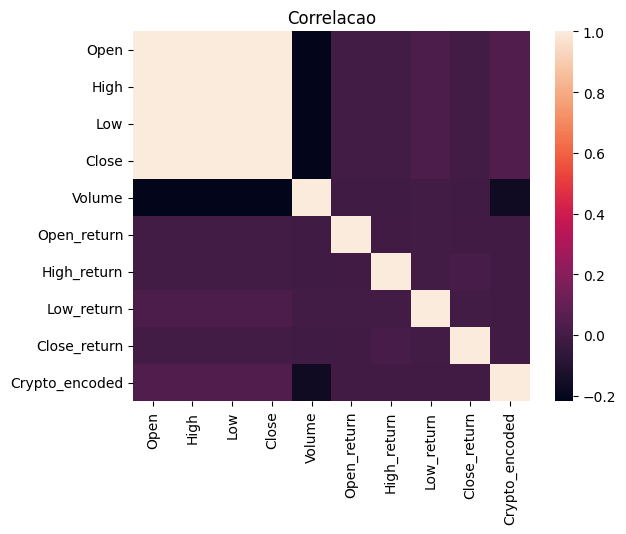

In [78]:
# cria um mapa de cores dos valores da correlação
sns.heatmap(df_correlation,
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns)

plt.title('Correlacao')
plt.show()

Resultados:

- Alta correlação entre preços (>0.99)
- Baixa correlação entre retornos (<0.01)
- Correlação negativa moderada entre Volume e preços (-0.22)
- Correlação insignificante entre retornos e volume

Observações Importantes:

Qualidade dos Dados:

- Dataset bem estruturado e completo
- Sem valores ausentes
- Poucos outliers extremos


Padrões Identificados:

- Maioria das criptomoedas em risco médio  
- Stablecoins claramente identificáveis  
- Alta volatilidade concentrada em poucas moedas  


Insights Relevantes:

- 6 criptomoedas com volatilidade muito alta (>300%)  
- 67 criptomoedas com drawdown significativo (>90%)  
- 5 criptomoedas com beta elevado (>1.5)